# FOOD AND BEVERAGE BUSINESS OPPORTUNITY SEEKER

This is an independent project centered around data science application in food and beverage industry. 

## Table of Contents

1. Introduction
2. Data
3. Methodology
4. Let's Do This

	4.1. Web Scrapping
    
	4.2. Get longitude and latitude of each neighborhood
    
	4.3. Get list of food venues near each neighborhood
    
	4.4. Analyze these data using descriptive statistics
    
	4.5. Cluster all these food venues using k-Mean algorithm
    
		4.5.1. Data Preparation
		4.5.2. Clustering
		4.5.3. Cluster Visualization
		4.5.4. Cluster Analysis
        
5. Discussion
6. Conclusion
7. Future Direction

## 1. Introduction

There is a businessman lives in the capital city of Indonesia, Jakarta. He wants to start a food and Beverage (FnB) business in the city where he is living, but he doesn't know how to start. Without any experience in this kind of business, he comes to us and tells us about his plan. This new businessman has two critical questions here, they are:
1. What kind of food and beverage business that he should start with?
2. Where in the city should he start this business?

He hopes that we can help him to answer these questions to lead him make a right decision. As a Data Scientist, you are challenged to support him by giving him best recommendation in order to build a sucessful FnB business.

## 2. Data

In order to answer those two questions, as a data scientist, we need to have data related to the food and beverage market in Jakarta. But first, we need to have list of neighborhoods in Jakarta to find the list of existing foods venues near each neighborhood.

In Indonesia, we name neighborhood as "Kecamatan". We will use list of neighborhood in the city of Jakarta from wikipedia page (<a href="https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta">here</a>). The coordinate of the neighborhood will be used to find nearest food venues. Foursquare has public API that can provide us the data.  Foursquare has some account tiers for developers. Each tier has different set of available features. You can read the full documentation <a href="https://developer.foursquare.com/comparison">here</a> and <a href="https://developer.foursquare.com/docs">here</a>. In this project we are using personal tier. You can see the available endpoint for this tier <a href="https://developer.foursquare.com/docs/api/endpoints">here</a>. In this tier, we can get the data of venues near the specific location with specific category. We can use this endpoint to find existing restaurant venues in Jakarta. The data should contain:
+ longitude
+ latitude
+ venue category

We will do some analysis on this data to answer the two questions. We can use the data in determining what kind of FnB business that we want to begin with and in which neighborhood we should start our new business.

## 3. Methodology

There are steps that we need to do to answer the business problem. Here they are:
1. Web scrapping Wikipedia Page to get list of neighborhood in Jakarta
2. Get longitude and latitude of each neighborhood
3. Get list of food venues near each neighborhood
4. Analyze these data using descriptive statistics
5. Cluster all these food venues using k-Mean algorithm
6. Analyze each cluster using bar chart of top nearby venue types vs frequency
7. Visualize the clusters in map

### 4. Let's Do This

Let's import all necessary library

In [32]:
# Basic Library
import pandas as pd
import numpy as np

# Library for http request operation and Web scrapping
import requests
from bs4 import BeautifulSoup

# library for geocoding
from geopy.geocoders import Nominatim
import time

# Library for visualization
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Library for k-means clustering
from sklearn.cluster import k_means

#### 4.1. Web Scrapping

We will retrieve list of neighborhood in Jakarta from wikipedia page <a href="https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta">here</a> using beautifulsoup module. 

In [2]:
# URL of the wikipedia page
url = "https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta"
source = requests.get(url).text

# Create beautiful soup object
soup = BeautifulSoup(source, 'lxml')

# Find table that contains the neighborhoods data in the page
tables = soup.findAll("table", {"class": "wikitable sortable"})
jakarta_regions = ["Jakarta Pusat", "Jakarta Utara", "Jakarta Timur", "Jakarta Selatan", "Jakarta Barat"]

neighborhood_df = pd.DataFrame({"Region":[], "Neighborhood":[]})
for i,table in enumerate(tables[1:-1]):
    body = table.find('tbody')
    region = jakarta_regions[i]
    for row in body.find_all('tr')[1:-1]:
        items = row.find_all('td')
        neighborhood_name = items[1].a.text
        new_row = {"Region":region, "Neighborhood":neighborhood_name}
        neighborhood_df = neighborhood_df.append(new_row, ignore_index=True)
        
neighborhood_df.head(10)

,Region,Neighborhood
0,Jakarta Pusat,Cempaka Putih
1,Jakarta Pusat,Cempaka Putih
2,Jakarta Pusat,Johar Baru
3,Jakarta Pusat,Kemayoran
4,Jakarta Pusat,Menteng
5,Jakarta Pusat,Sawah Besar
6,Jakarta Pusat,Senen
7,Jakarta Pusat,Tanah Abang
8,Jakarta Utara,Cilincing
9,Jakarta Utara,Kelapa Gading


With prior knowledge about the city neighborhood, I can see that there is an incorrect neighborhood name in the table. This mistake is in the wikipedia page. Two neighborhoods have the same name, but one of them is actually has a different name. Using my prior knowledge, I set one of them to the actual value, "Gambir". Yes, one missing neighborhood in Jakarta Pusat is Gambir. So let's replace one of them with Gambir.

In [3]:
neighborhood_df.iat[1,1] = "Gambir"
neighborhood_df.head()

,Region,Neighborhood
0,Jakarta Pusat,Cempaka Putih
1,Jakarta Pusat,Gambir
2,Jakarta Pusat,Johar Baru
3,Jakarta Pusat,Kemayoran
4,Jakarta Pusat,Menteng


#### 4.2. Get longitude and latitude of each neighborhood

In this section, we will try to get the coordinate of each neighborhood. We are using Nominatim API from geopy geocoding module for this. This API is an open source API and based on OpenStreetMap, it is not odd if the data of longitude and latitude available in this API is not complete. Let's try this.

In [4]:
# Function to get longitude and latitude of each neighborhood in neighborhood dataframe
def getLongLat(_neigh_df):
    # Create Nominatim geolocator agent object
    geolocator = Nominatim(user_agent="test")
    
    # new dataframe of longitude and latitude data
    longlat_df = pd.DataFrame({"Neighborhood":[], "Longitude":[], "Latitude":[]})
    
    #iterate through each row
    for index, row in _neigh_df.iterrows():
        neighborhood = row["Neighborhood"]
        region = row["Region"]
        location = geolocator.geocode(neighborhood + "," + region, timeout=5)
        new_row = {
            "Neighborhood": neighborhood,
            "Longitude": location.longitude,
            "Latitude": location.latitude,
        }
        
        longlat_df = longlat_df.append(new_row, ignore_index=True)
        time.sleep(1)
    _neigh_df.set_index("Neighborhood", inplace=True)
    longlat_df.set_index("Neighborhood", inplace=True)
    result_df = pd.concat([_neigh_df, longlat_df], axis=1)
    result_df.reset_index(inplace=True)
    return result_df

In [5]:
neigh_df = getLongLat(neighborhood_df)
neigh_df.head()

,Neighborhood,Region,Longitude,Latitude
0,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214
1,Gambir,Jakarta Pusat,106.816744,-6.171163
2,Johar Baru,Jakarta Pusat,106.855332,-6.183125
3,Kemayoran,Jakarta Pusat,106.856890,-6.162546
4,Menteng,Jakarta Pusat,106.832224,-6.195026


#### 4.3. Get list of food venues near each neighborhood

Foursquare Public API will provide us the data of nearby food venues in each neighborhood. We will use Explore Endpoint to find venues with category "Food" near each neighborhood coordinate. But first, we need to have client_id and client_secret to access the public API.

In [6]:
CLIENT_ID = 'VQG3LESIQX2EBRDST02BYBPDNHRXFVVVUHD3S1WEWWISTOPG' # your Foursquare ID
CLIENT_SECRET = 'BLIANNOYZTV55LD5TV3L5SP1NITYZJVYXD3NSIX505C1IASJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ', CLIENT_ID)
print('CLIENT_SECRET:', CLIENT_SECRET)

Your credentails:
CLIENT_ID:  VQG3LESIQX2EBRDST02BYBPDNHRXFVVVUHD3S1WEWWISTOPG
CLIENT_SECRET: BLIANNOYZTV55LD5TV3L5SP1NITYZJVYXD3NSIX505C1IASJ


Here, we create a python function to get list of nearby food venues with neighborhood dataframe as an argument. We limit our exploration by finding only 50 (max) food venues in radius 2000 meters here.

In [7]:
def getFoodVenues(_neigh_df, radius=2000):
    FOOD_CATEGORY_ID = "4d4b7105d754a06374d81259"
    LIMIT = 50
    venues_list=[]
    
    i = 1
#     for region, lat, lng in zip(regions, latitudes, longitudes): 
    for index,row in _neigh_df.iterrows():
        region = row["Region"]
        neighborhood = row["Neighborhood"]
        longitude = row["Longitude"]
        latitude = row["Latitude"]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT,
            FOOD_CATEGORY_ID)
        
#         print(url)
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except Exception as e:
            print("GAGAL")
            #print(results)
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood,
            region,
            latitude, 
            longitude, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Region',
                  'Latitude', 
                  'Longitude',
                  'Venue_ID',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    #return new dataframe
    return(nearby_venues)

In [8]:
jakarta_food_venues = getFoodVenues(neigh_df)
jakarta_food_venues.head()

,Neighborhood,Region,Latitude,Longitude,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Cempaka Putih,Jakarta Pusat,-6.181214,106.868548,4bf0d4da1f17ef3bb1d89bc8,Pagi Sore,-6.176376,106.871474,Padangnese Restaurant
1,Cempaka Putih,Jakarta Pusat,-6.181214,106.868548,558b4c3d498e521f198a3a5e,DIMSUM-ING,-6.176087,106.872188,Dim Sum Restaurant
2,Cempaka Putih,Jakarta Pusat,-6.181214,106.868548,4d09eb2333d6b60c5aac9785,Soto Jakarta - Mas Hari,-6.172202,106.874084,Soup Place
3,Cempaka Putih,Jakarta Pusat,-6.181214,106.868548,51b15e58498ee0351be08cf2,Mie ayam pangsit ACOI,-6.176125,106.865826,Indonesian Restaurant
4,Cempaka Putih,Jakarta Pusat,-6.181214,106.868548,5b2b50f99411f200339c3b29,Surabi Enhaii Cempaka Putih,-6.176321,106.872056,Café


In [9]:
jakarta_food_venues.shape

(1934, 9)

#### 4.4. Analyze these data using descriptive statistics


In [37]:
food_venues_group = jakarta_food_venues.groupby(by=["Venue_Category"]).count()
food_venues_group = food_venues_group[["Neighborhood"]]
food_venues_group.rename(columns={"Neighborhood":"Count"}, inplace=True)
food_venues_group.sort_values(by=["Count"], axis=0, inplace=True, ascending=False)
food_venues_group.head()

,Count
Venue_Category,
Indonesian Restaurant,248
Asian Restaurant,143
Noodle House,133
Chinese Restaurant,123
Food Truck,101


In [20]:
food_venues_group.shape

(78, 1)

In [38]:
top_10_food_venue_type = food_venues_group.head(10)
top_10_food_venue_type

,Count
Venue_Category,
Indonesian Restaurant,248
Asian Restaurant,143
Noodle House,133
Chinese Restaurant,123
Food Truck,101
Restaurant,96
Pizza Place,85
Café,84
Fast Food Restaurant,81


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

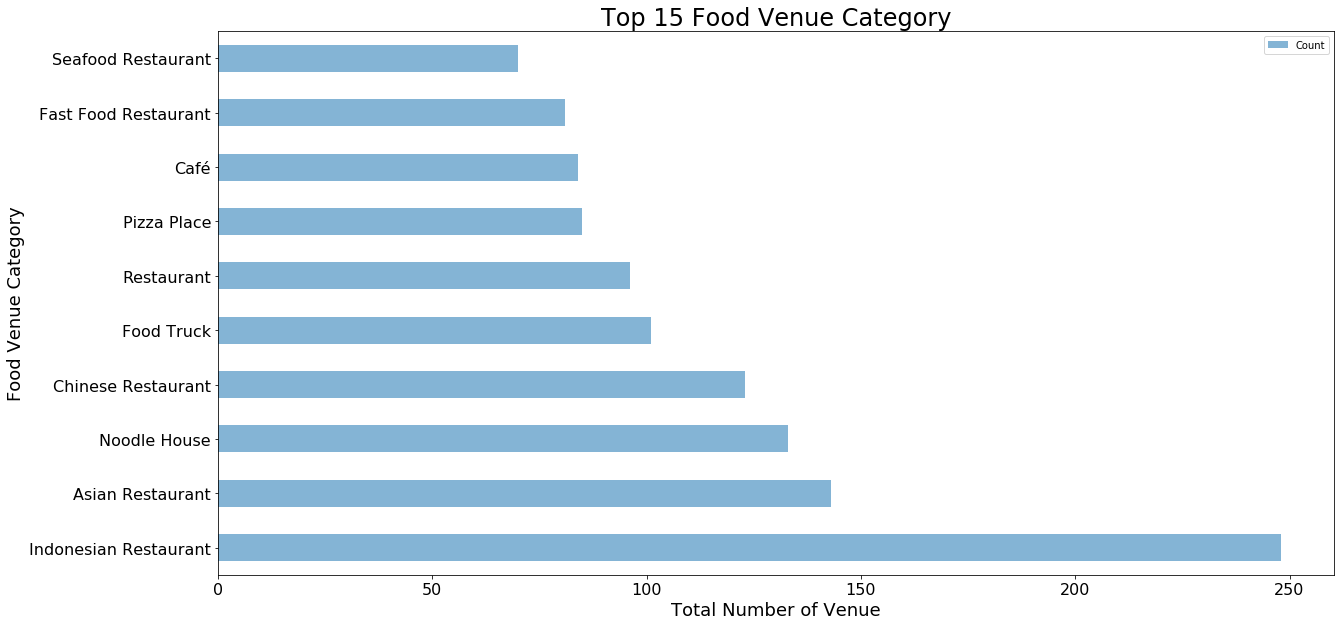

In [46]:
top_10_food_venue_type.plot(kind="barh", alpha=0.55, figsize=(20,10))
plt.title("Top 15 Food Venue Category",fontsize=24)
plt.xlabel("Total Number of Venue", fontsize=18)
plt.ylabel("Food Venue Category",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#### 4.5. Cluster all these food venues using k-Mean algorithm

##### 4.5.1. Data Preparation

In [22]:
# one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_food_venues[['Venue_Category']], prefix="", prefix_sep="")

columns = jakarta_onehot.columns

# add neighborhood column back to dataframe
jakarta_onehot['Neighborhood'] = jakarta_food_venues['Neighborhood'] 
jakarta_onehot['Region'] = jakarta_food_venues['Region']
jakarta_onehot['Longitude'] = jakarta_food_venues['Longitude']
jakarta_onehot['Latitude'] = jakarta_food_venues['Latitude']

# move neighborhood column to the first column
fixed_columns = ["Neighborhood", "Region", "Longitude", "Latitude"] + list(columns)
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot.head()

,Neighborhood,Region,Longitude,Latitude,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
jakarta_grouped = jakarta_onehot.groupby("Neighborhood").mean().reset_index()
jakarta_grouped.head()

,Neighborhood,Longitude,Latitude,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Cakung,106.940109,-6.185562,0.00,0.0,0.0,0.035714,0.0,0.035714,0.071429,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
1,Cempaka Putih,106.868548,-6.181215,0.02,0.0,0.0,0.040000,0.0,0.040000,0.040000,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
2,Cengkareng,106.744718,-6.152898,0.00,0.0,0.0,0.029412,0.0,0.029412,0.058824,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.029412,0.0,0.00
3,Cilandak,106.804863,-6.283818,0.00,0.0,0.0,0.060000,0.0,0.000000,0.060000,...,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.000000,0.0,0.02
4,Cilincing,106.944454,-6.129015,0.00,0.0,0.0,0.250000,0.0,0.000000,0.000000,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00


In [25]:
jakarta_grouped.shape

(42, 81)

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = jakarta_grouped['Neighborhood']

for ind in np.arange(jakarta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cakung,Food Truck,Food Court,Restaurant,Indonesian Restaurant,Pizza Place,Chinese Restaurant,Noodle House,Fast Food Restaurant,Bakery,BBQ Joint
1,Cempaka Putih,Pizza Place,Indonesian Restaurant,Restaurant,Café,Seafood Restaurant,Soup Place,Japanese Restaurant,Food Truck,Bakery,BBQ Joint
2,Cengkareng,Food Truck,Café,Noodle House,Pizza Place,Bakery,Fast Food Restaurant,Italian Restaurant,Indonesian Restaurant,Chinese Restaurant,Indonesian Meatball Place
3,Cilandak,Food Truck,French Restaurant,Indonesian Restaurant,Café,Fast Food Restaurant,Padangnese Restaurant,Bakery,Asian Restaurant,Snack Place,Diner
4,Cilincing,Asian Restaurant,Indonesian Restaurant,Diner,Seafood Restaurant,Wings Joint,Fast Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant


##### 4.5.2. Clustering

In [28]:
# set number of clusters
kclusters = 6

jakarta_grouped_clustering = jakarta_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = k_means(X=jakarta_grouped_clustering, n_clusters=kclusters, random_state=0)

# check cluster labels generated for each row in the dataframe
len(kmeans[1])

42

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans[1])

jakarta_merged = neigh_df

# merge jakarta_grouped with jakarta_neighborhood_df to add latitude/longitude for each neighborhood
jakarta_merged = jakarta_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [30]:
jakarta_merged.head() # check the last columns!

,Neighborhood,Region,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214,2,Pizza Place,Indonesian Restaurant,Restaurant,Café,Seafood Restaurant,Soup Place,Japanese Restaurant,Food Truck,Bakery,BBQ Joint
1,Gambir,Jakarta Pusat,106.816744,-6.171163,0,Indonesian Restaurant,Noodle House,Seafood Restaurant,Chinese Restaurant,Asian Restaurant,Soup Place,Padangnese Restaurant,Korean Restaurant,Pizza Place,Manadonese Restaurant
2,Johar Baru,Jakarta Pusat,106.855332,-6.183125,3,Indonesian Restaurant,Fast Food Restaurant,Chinese Restaurant,Seafood Restaurant,Restaurant,Café,Pizza Place,Soup Place,Padangnese Restaurant,Asian Restaurant
3,Kemayoran,Jakarta Pusat,106.856890,-6.162546,3,Indonesian Restaurant,Chinese Restaurant,Café,Food Truck,Sundanese Restaurant,Seafood Restaurant,Noodle House,Diner,Restaurant,Japanese Restaurant
4,Menteng,Jakarta Pusat,106.832224,-6.195026,3,Indonesian Restaurant,Restaurant,Steakhouse,Chinese Restaurant,Buffet,Japanese Restaurant,Thai Restaurant,Bakery,Breakfast Spot,Mediterranean Restaurant


##### 4.5.3. Cluster Visualization

In [31]:
# create map
map_clusters = folium.Map(location=[-6.2088, 106.8456], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_merged['Latitude'], jakarta_merged['Longitude'], jakarta_merged['Neighborhood'], jakarta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### 4.5.4. Cluster Analysis

In [51]:
Cluster_0 = jakarta_merged[jakarta_merged["Cluster Labels"] == 0]
# Cluster_0.plot(kind="barh", alpha=0.55, figsize=(20,10))
# plt.title("Top 15 Food Venue Category",fontsize=24)
# plt.xlabel("Total Number of Venue", fontsize=18)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

,Neighborhood,Region,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Gambir,Jakarta Pusat,106.816744,-6.171163,0,Indonesian Restaurant,Noodle House,Seafood Restaurant,Chinese Restaurant,Asian Restaurant,Soup Place,Padangnese Restaurant,Korean Restaurant,Pizza Place,Manadonese Restaurant
5,Sawah Besar,Jakarta Pusat,106.833580,-6.155891,0,Noodle House,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Indonesian Restaurant,Food Truck,Restaurant,Pizza Place,Steakhouse,BBQ Joint
12,Penjaringan,Jakarta Utara,106.767433,-6.117265,0,Chinese Restaurant,Seafood Restaurant,Noodle House,Indonesian Restaurant,Japanese Restaurant,Dim Sum Restaurant,Café,Bakery,Balinese Restaurant,Food Truck
35,Grogol Petamburan,Jakarta Barat,106.788317,-6.164188,0,Noodle House,Chinese Restaurant,Indonesian Restaurant,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Indonesian Meatball Place,Korean Restaurant,BBQ Joint,Restaurant
36,Taman Sari,Jakarta Barat,106.818499,-6.146142,0,Chinese Restaurant,Noodle House,Asian Restaurant,Food Truck,Bakery,Restaurant,BBQ Joint,Padangnese Restaurant,Japanese Restaurant,Dim Sum Restaurant


In [59]:
Cluster_0_onehot = pd.get_dummies(Cluster_0[['1st Most Common Venue']], prefix="", prefix_sep="")
Cluster_0_onehot

,Chinese Restaurant,Indonesian Restaurant,Noodle House
1,0,1,0
5,0,0,1
12,1,0,0
35,0,0,1
36,1,0,0
37,1,0,0
39,0,0,1


Cluster_0_grouped = Cluster_0_onehot.join(Cluster_0[["Neighborhood"]])
Cluster_0_grouped = Cluster_0_grouped.groupby(by="Neighborhood").sum()
Cluster_0_grouped

#### 5. Discussion

#### 6. Conclusion 

#### 7. Future Direction